# MOSCOW REAL ESTATE PRICES
**_Doing to houses & apartments what we did to cars_**
### Data Science 410 BB
#### University of Washington Professional & Continuing Education
#### FINAL PROJECT
#### Leo Salemann, 3/10/18

# INTRODUCTION

Our dataset comes from a [Kaggle competition to predict real Moscow esate prices](https://www.kaggle.com/c/sberbank-russian-housing-market). I first encountered this data in a [team project](https://www.slideshare.net/LeoSalemann/predicting-moscow-real-estate-prices-with-azure-machine-learning) for [UW PCE Big Data Technologies - Introduciton to Data Engineering](https://www.pce.uw.edu/courses/introduction-to-data-engineering). We used [Microsoft Azure Machine Learning Studio](https://gallery.cortanaintelligence.com/Experiment/D-Hawks-Big-Data-Project-Leo-RevS) to look at multiple approaches to feature engineering, and try multiple machine learning models simultaneosly. For this project, we'll extract realestate data from Azure ML Studio, after cleaning but before any Azure ML modeling.  We'll then do our own feature analysis in Jupyter Notebook with R.

The [original kaggle datasets](https://www.kaggle.com/c/sberbank-russian-housing-market/data) consisted of two tables: Real Estate Transactions and Macro Economics. The Real Estate Transactions table includes price, timestamp, year built, property descriptors such as  square footage, number of floors, condition, etc. and neighborhood descriptors such as nearby transportation, industry, population demographics. 

Azure ML Studio Summary
1. Start with the original 30,471 rows and 292 columns
1. Select 64 columns to work with.
1. Set a bunch of numeric data to floating point, integer, category
1. Clean missing data
1. Apply SQL Transofmation (see below)
1. Normalize non-categorical rows


Cleaning missing data

|Field                         |Set To   |Rows Affected|
|------------------------------|---------|-------------|
|build_year                    |1979     |13,605       |
|life_sq (living space, m$^2$) |30       | 6,383       |
|floor (level above ground)    |7        |   167       |
|num_room                      |2        | 9,572       |
|kitch_sq (kitchen space m$^2$)|6        | 9,572       |
|material                      |mode\*   | 9,672       |
|state                         |MICE\*\* |0            |
|full_sq (total m$^2$)         |mode\*   |0            |
|max_floor (highest, 0=ground) |0        | 9,571       |
|metro_min_walk                |median   |    25       |
|railroad_station_walk_km      |median   |    25       |
|railroad_station_walk_min     |median   |    25       |
|metro_km_walk                 |median   |    25       |




\* replace nulls with the mode of the non-null data

\*\* [Multivariate Imputation using Chaned Equations](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/clean-missing-data)

## SQL Filtering

# DATA EXPLORATION

## Load the data, have a quick look

In [1]:
# real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql_normed.csv")
real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql.csv")
dim(real_estate)
head(real_estate)
str(real_estate)

[1] 15693    64

timestamp             full_sq life_sq floor max_floor material build_year
1 4/27/2013 12:00:00 AM 73      36      17    17        1        1979      
2 5/25/2013 12:00:00 AM 53      30      10    16        1        1980      
3 5/27/2013 12:00:00 AM 41      37      13    17        1        1979      
4 5/27/2013 12:00:00 AM 77      41       2    17        6        2014      
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
  num_room kitch_sq state ⋯ prom_part_2000 office_count_2000 office_sqm_2000
1 2        11       3     ⋯  8.44           0                     0         
2 2         8       3     ⋯ 17.64          10                179554         
3 1         1       1     ⋯  1.45           0                     0         
4 3        12       1     ⋯  1.64           0                     0         
5 2         6       3     ⋯  0.74           0                     0         
6 1         8       3     ⋯ 21.51           4                 31280         
  prom_part_3000 office_count_3000 office_sqm_3000 prom_part_5000
1  8.28           0                     0           6.22         
2 16.69          14                529054          18.47         
3  2.01           0                     0           4.45         
4  1.98           0                     0           4.75         
5  1.99           1                 15000           8.05         
6 18.78          15                136990          11.12         
  office_count_5000 office_sqm_5000 price_doc
1  2                 138650         10100000 
2 25                 766701          9000000 
3  0                      0          4457400 
4  0                      0          7011550 
5  3                  81947          7100000 
6 83                3903973          6450000

'data.frame':	15693 obs. of  64 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 335 382 387 387 387 390 390 395 416 464 ...
 $ full_sq                          : int  73 53 41 77 45 38 63 74 51 77 ...
 $ life_sq                          : int  36 30 37 41 27 20 30 46 30 50 ...
 $ floor                            : int  17 10 13 2 6 15 17 12 7 3 ...
 $ max_floor                        : int  17 16 17 17 9 16 17 24 17 5 ...
 $ material                         : int  1 1 1 6 1 1 4 1 1 2 ...
 $ build_year                       : int  1979 1980 1979 2014 1970 1982 2013 2004 2003 1957 ...
 $ num_room                         : int  2 2 1 3 2 1 2 3 2 3 ...
 $ kitch_sq                         : int  11 8 1 12 6 8 1 9 9 8 ...
 $ state                            : int  3 3 1 1 3 3 1 3 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 2 1 1 2 1 1 1 ...
 $ sub_area                         : Factor 

## Data Cleanups
 - **Drop NA Values**
 - **Parse the Date**
 - **Create a price per square meter**

In [2]:
real_estate = na.omit(real_estate)
dim(real_estate)
real_estate$date = as.Date(real_estate$timestamp,format='%m/%d/%Y')
real_estate$year_sold  = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%Y'))
real_estate$month_sold = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%m'))
real_estate$day_sold   = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%d'))
real_estate$price_sqm = real_estate$price_doc/real_estate$full_sq
head(real_estate, 3)
str(real_estate)

[1] 9233   64

timestamp             full_sq life_sq floor max_floor material build_year
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7 5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
  num_room kitch_sq state ⋯ office_sqm_3000 prom_part_5000 office_count_5000
5 2        6        3     ⋯  15000           8.05           3               
6 1        8        3     ⋯ 136990          11.12          83               
7 2        1        1     ⋯      0           6.54           1               
  office_sqm_5000 price_doc date       year_sold month_sold day_sold price_sqm
5   81947         7100000   2013-05-27 2013      5          27       157777.78
6 3903973         6450000   2013-05-28 2013      5          28       169736.84
7   26950         5903808   2013-05-28 2013      5          28        93711.24

'data.frame':	9233 obs. of  69 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

## Density Plot for Price

Loading required package: ggplot2


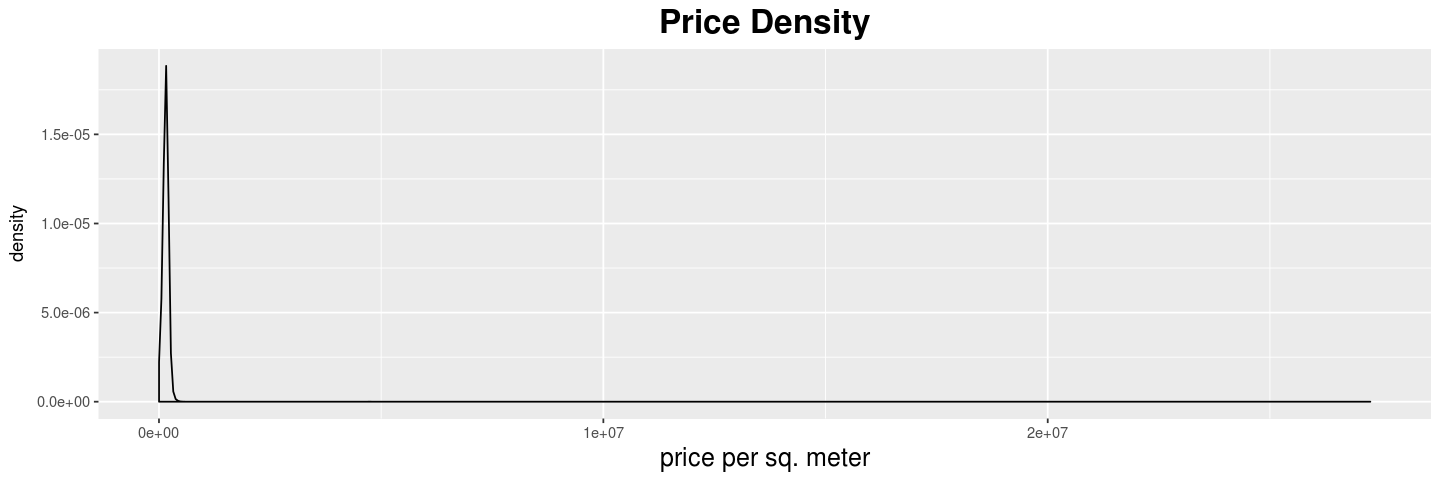

In [4]:
require(ggplot2)
options(repr.plot.width=12, repr.plot.height=4)
ggplot(real_estate, aes(price_sqm)) + 
      geom_density() + 
      xlab("price per sq. meter") + 
      ggtitle("Price Density") + 
      theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"),
           axis.title.x = element_text(size=15))

In [ ]:
## Max Floors

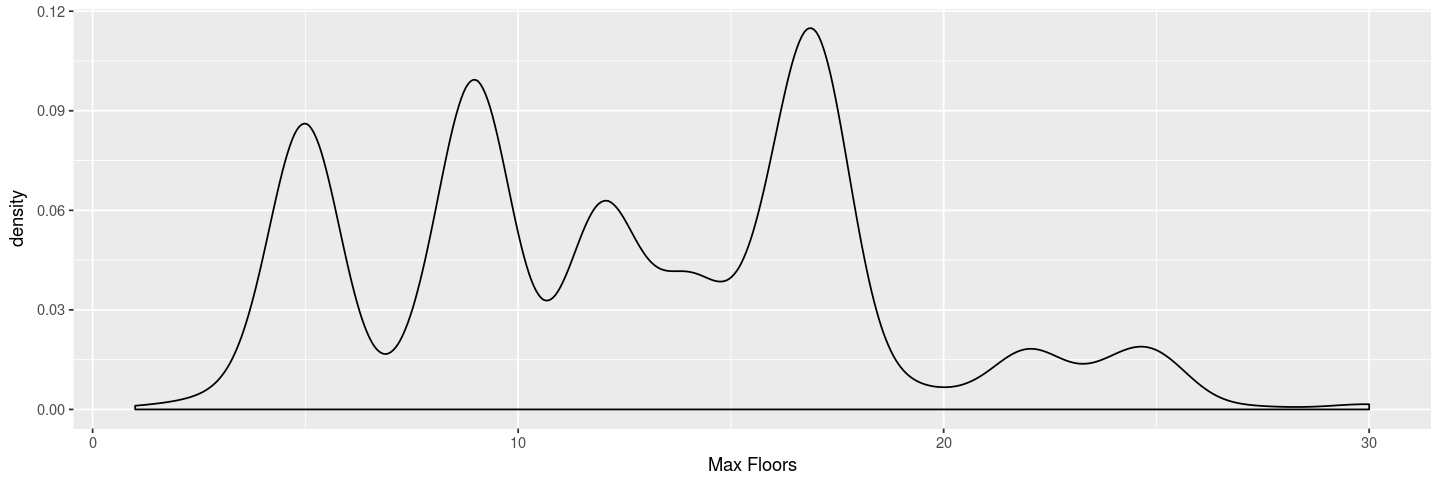

In [44]:
ggplot(real_estate, aes(max_floor)) + geom_density() + 
xlab('Max Floors')

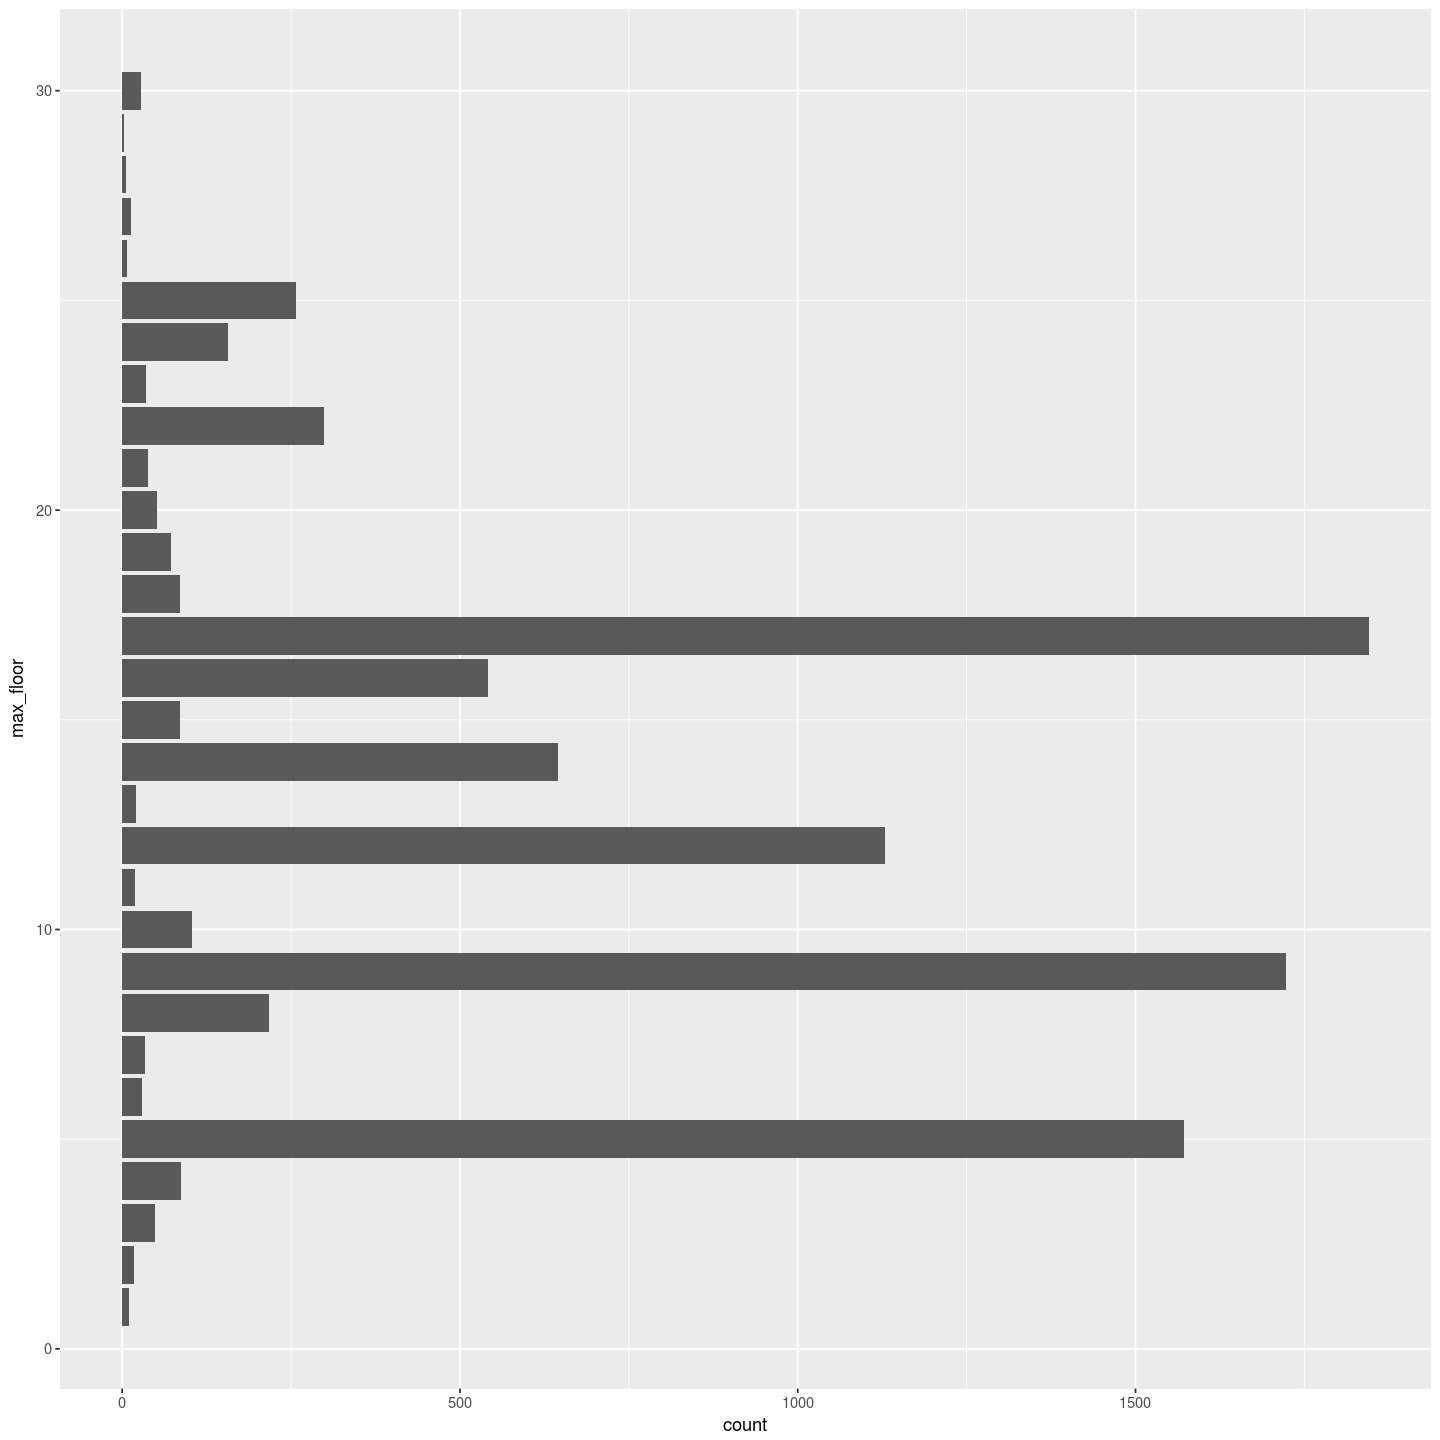

In [53]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(real_estate, aes(max_floor)) + geom_bar() + coord_flip()

## Floor

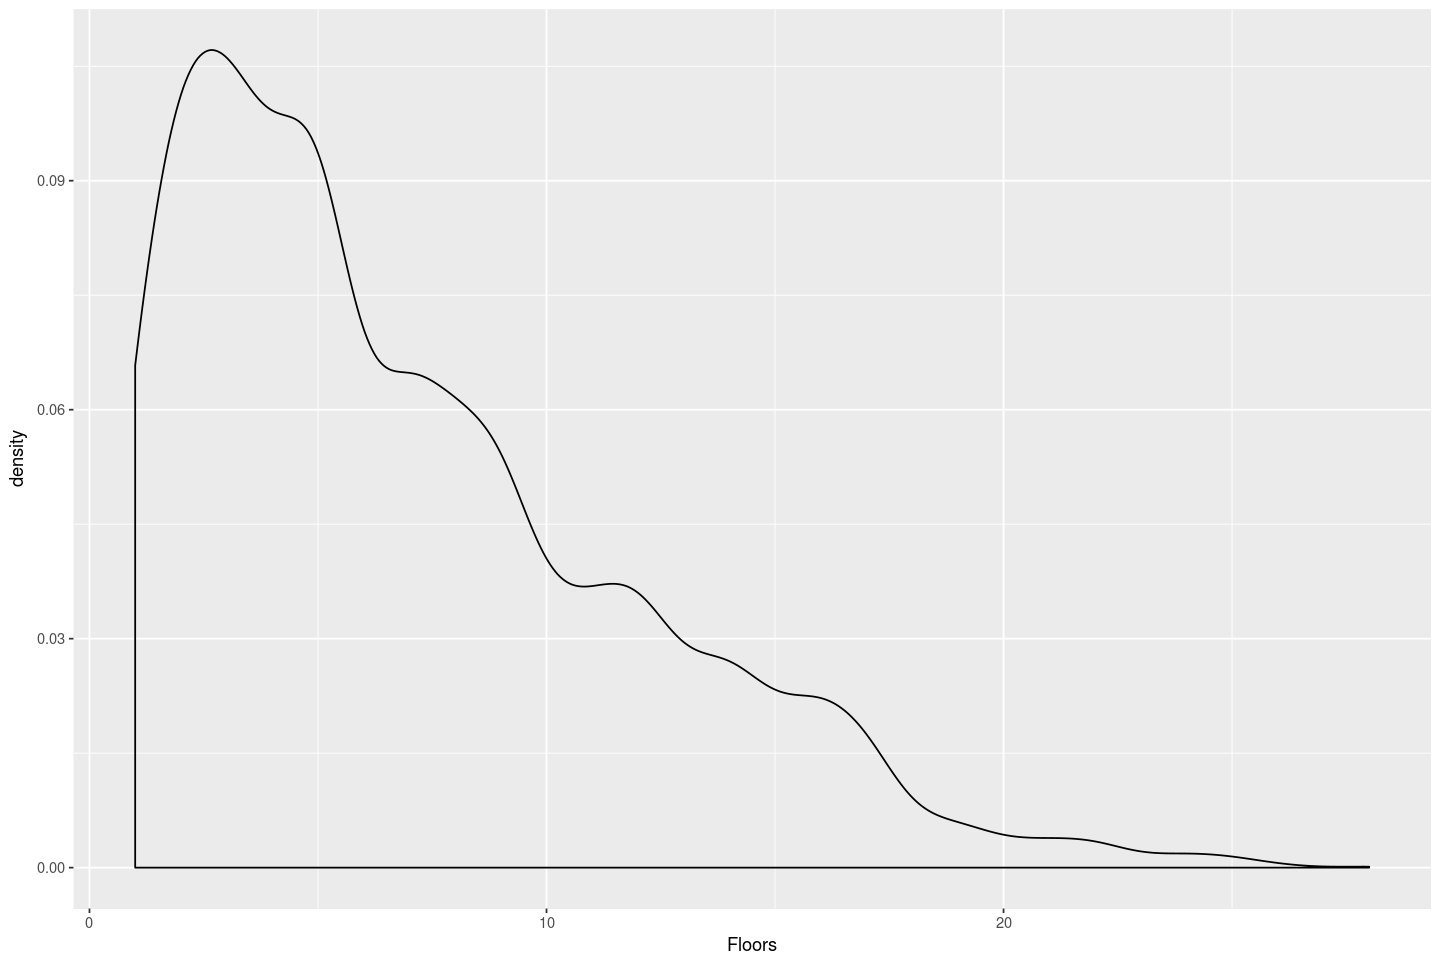

In [58]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(real_estate, aes(floor)) + geom_density() + 
xlab('Floors')

In [55]:
head(real_estate,3

timestamp             full_sq life_sq floor max_floor material build_year
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7 5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
  num_room kitch_sq state ⋯ prom_part_5000 office_count_5000 office_sqm_5000
5 2        6        3     ⋯  8.05           3                  81947        
6 1        8        3     ⋯ 11.12          83                3903973        
7 2        1        1     ⋯  6.54           1                  26950        
  price_doc date       year_sold month_sold day_sold price_sqm log.price_sqm
5 7100000   2013-05-27 2013      5          27       157777.78 11.96894     
6 6450000   2013-05-28 2013      5          28       169736.84 12.04200     
7 5903808   2013-05-28 2013      5          28        93711.24 11.44797

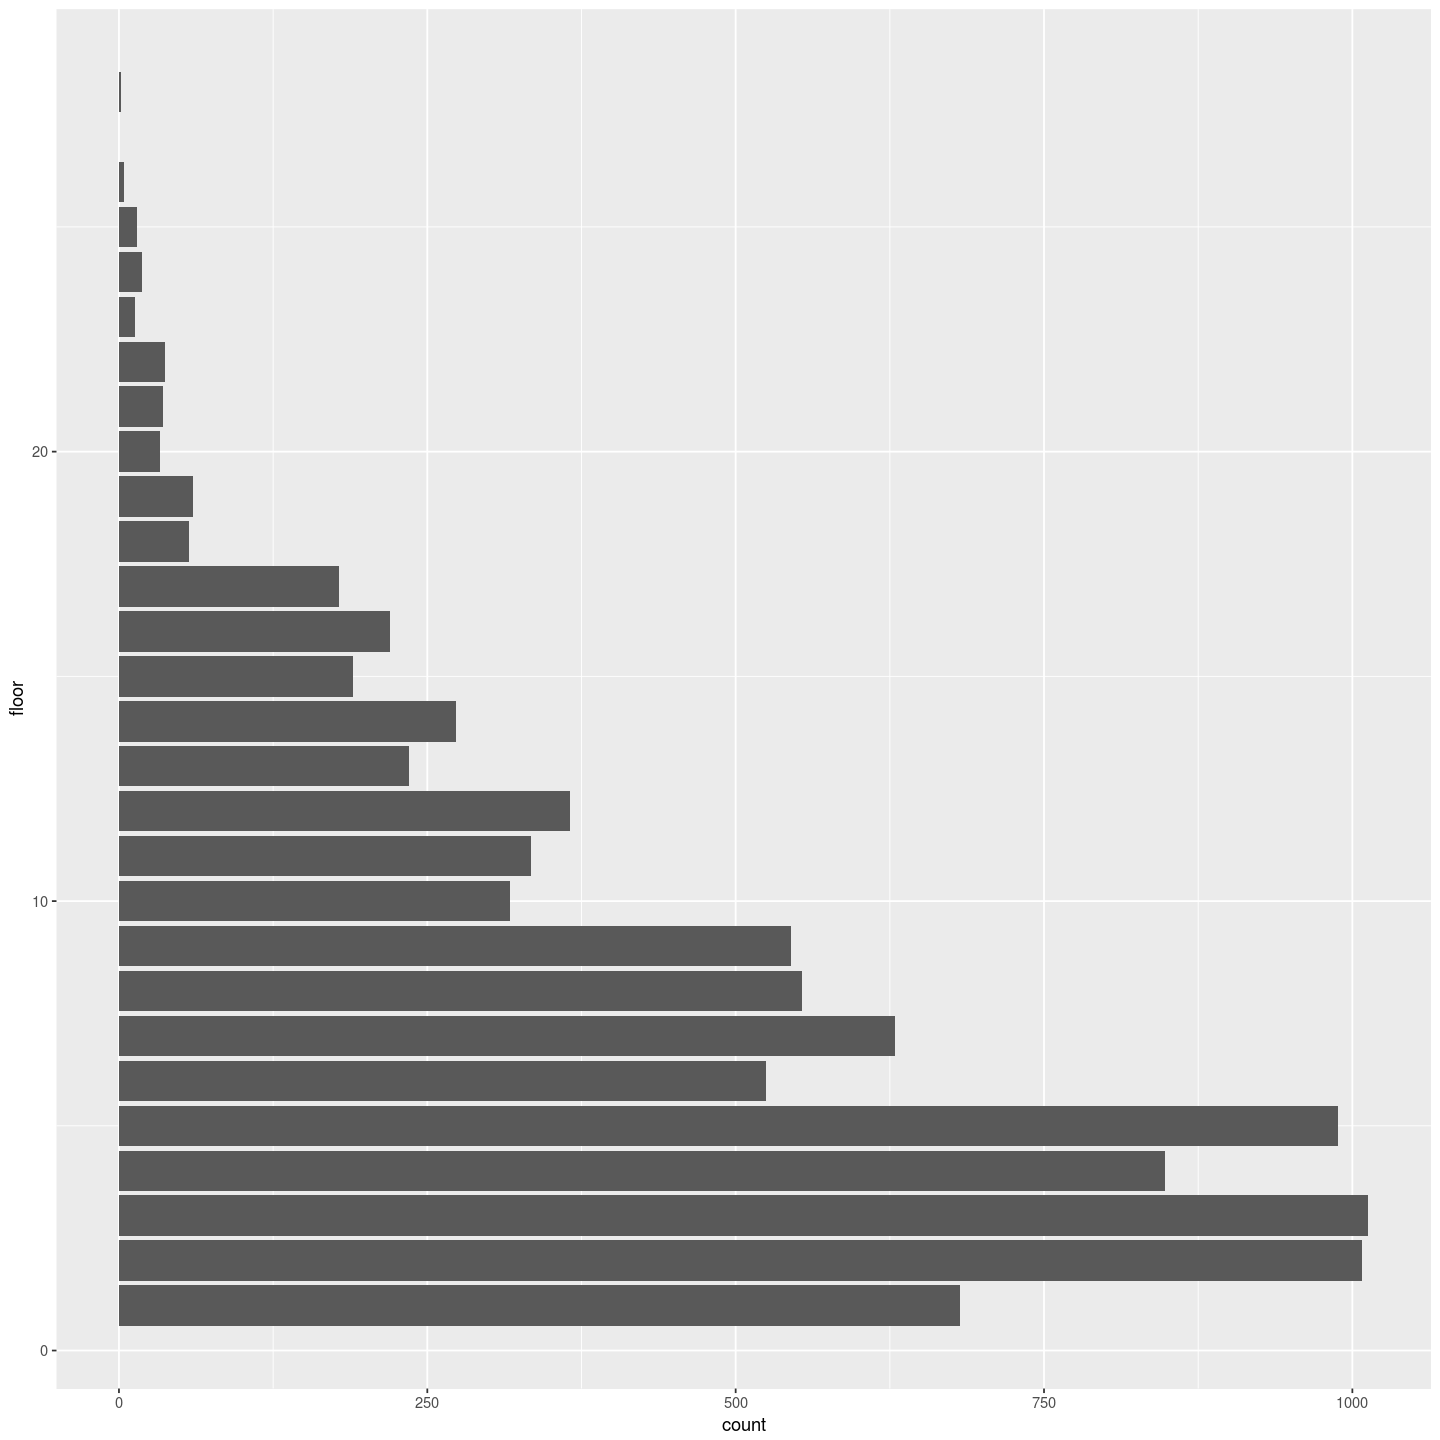

In [59]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(real_estate, aes(floor)) + geom_bar() + coord_flip()

## Sub Area

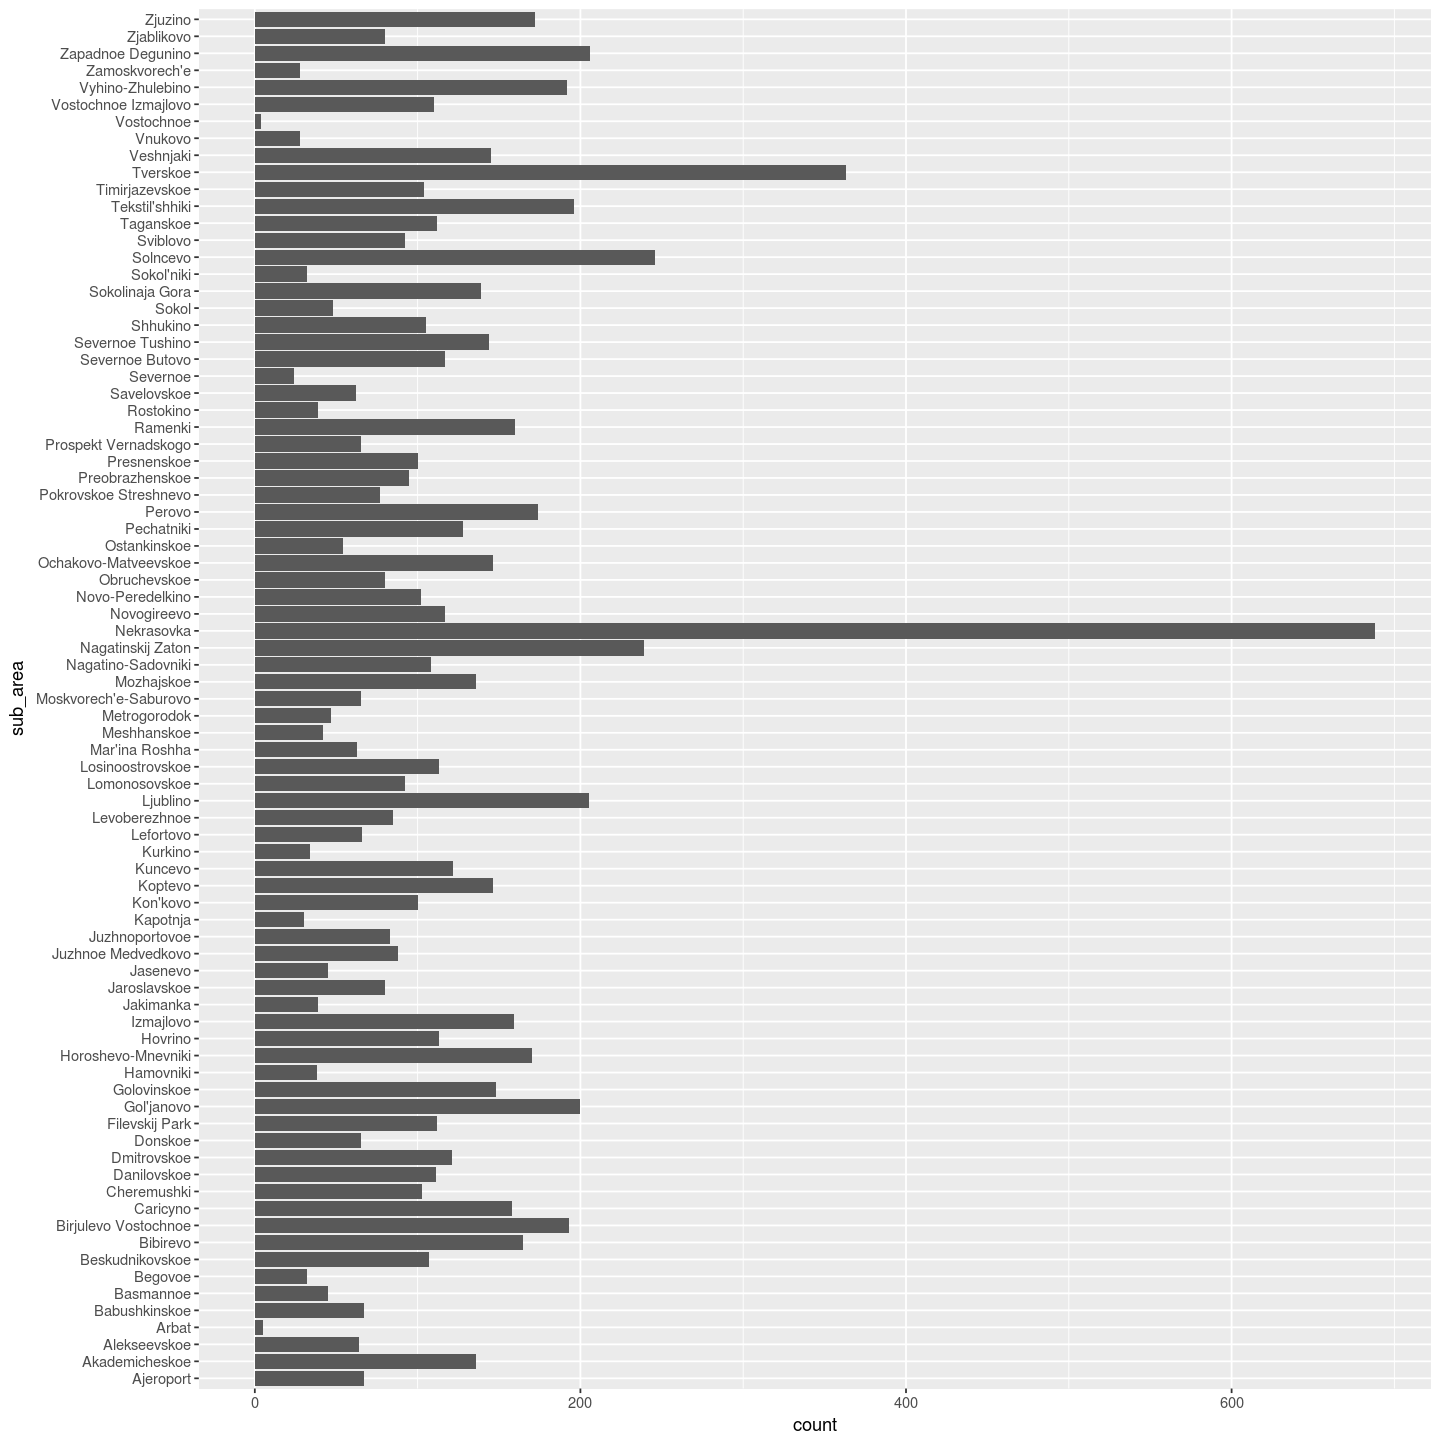

In [42]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(real_estate, aes(sub_area)) + geom_bar() + coord_flip()

## Take the log, Plot again

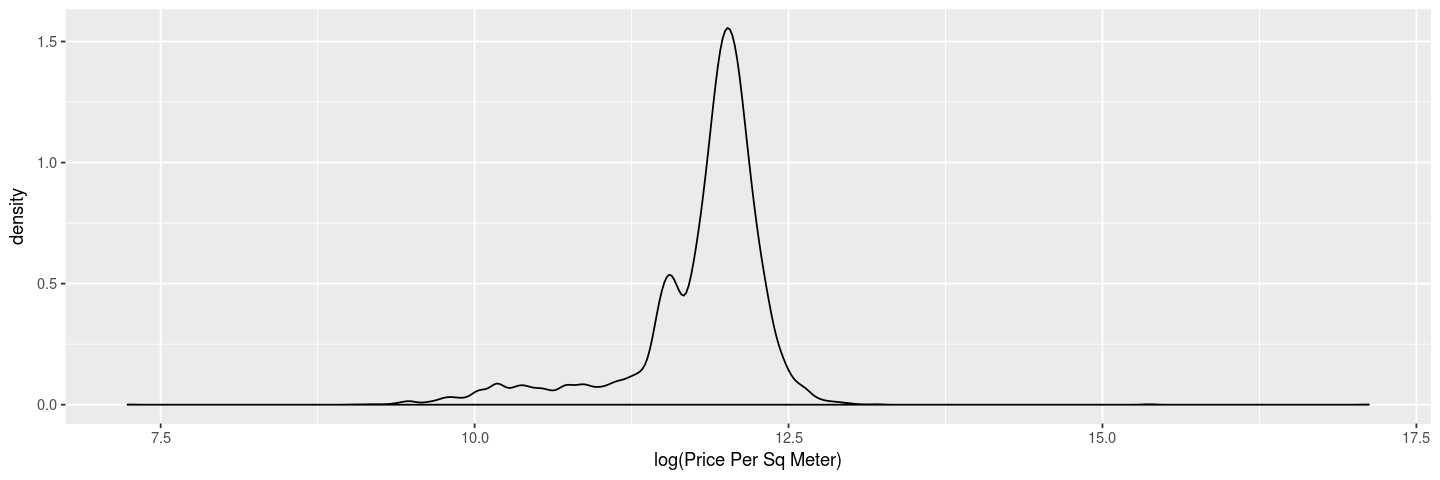

In [5]:
options(repr.plot.width=12, repr.plot.height=4)
real_estate$log.price_sqm = log(real_estate$price_sqm)
ggplot(real_estate, aes(log.price_sqm)) + geom_density() + 
xlab('log(Price Per Sq Meter)')

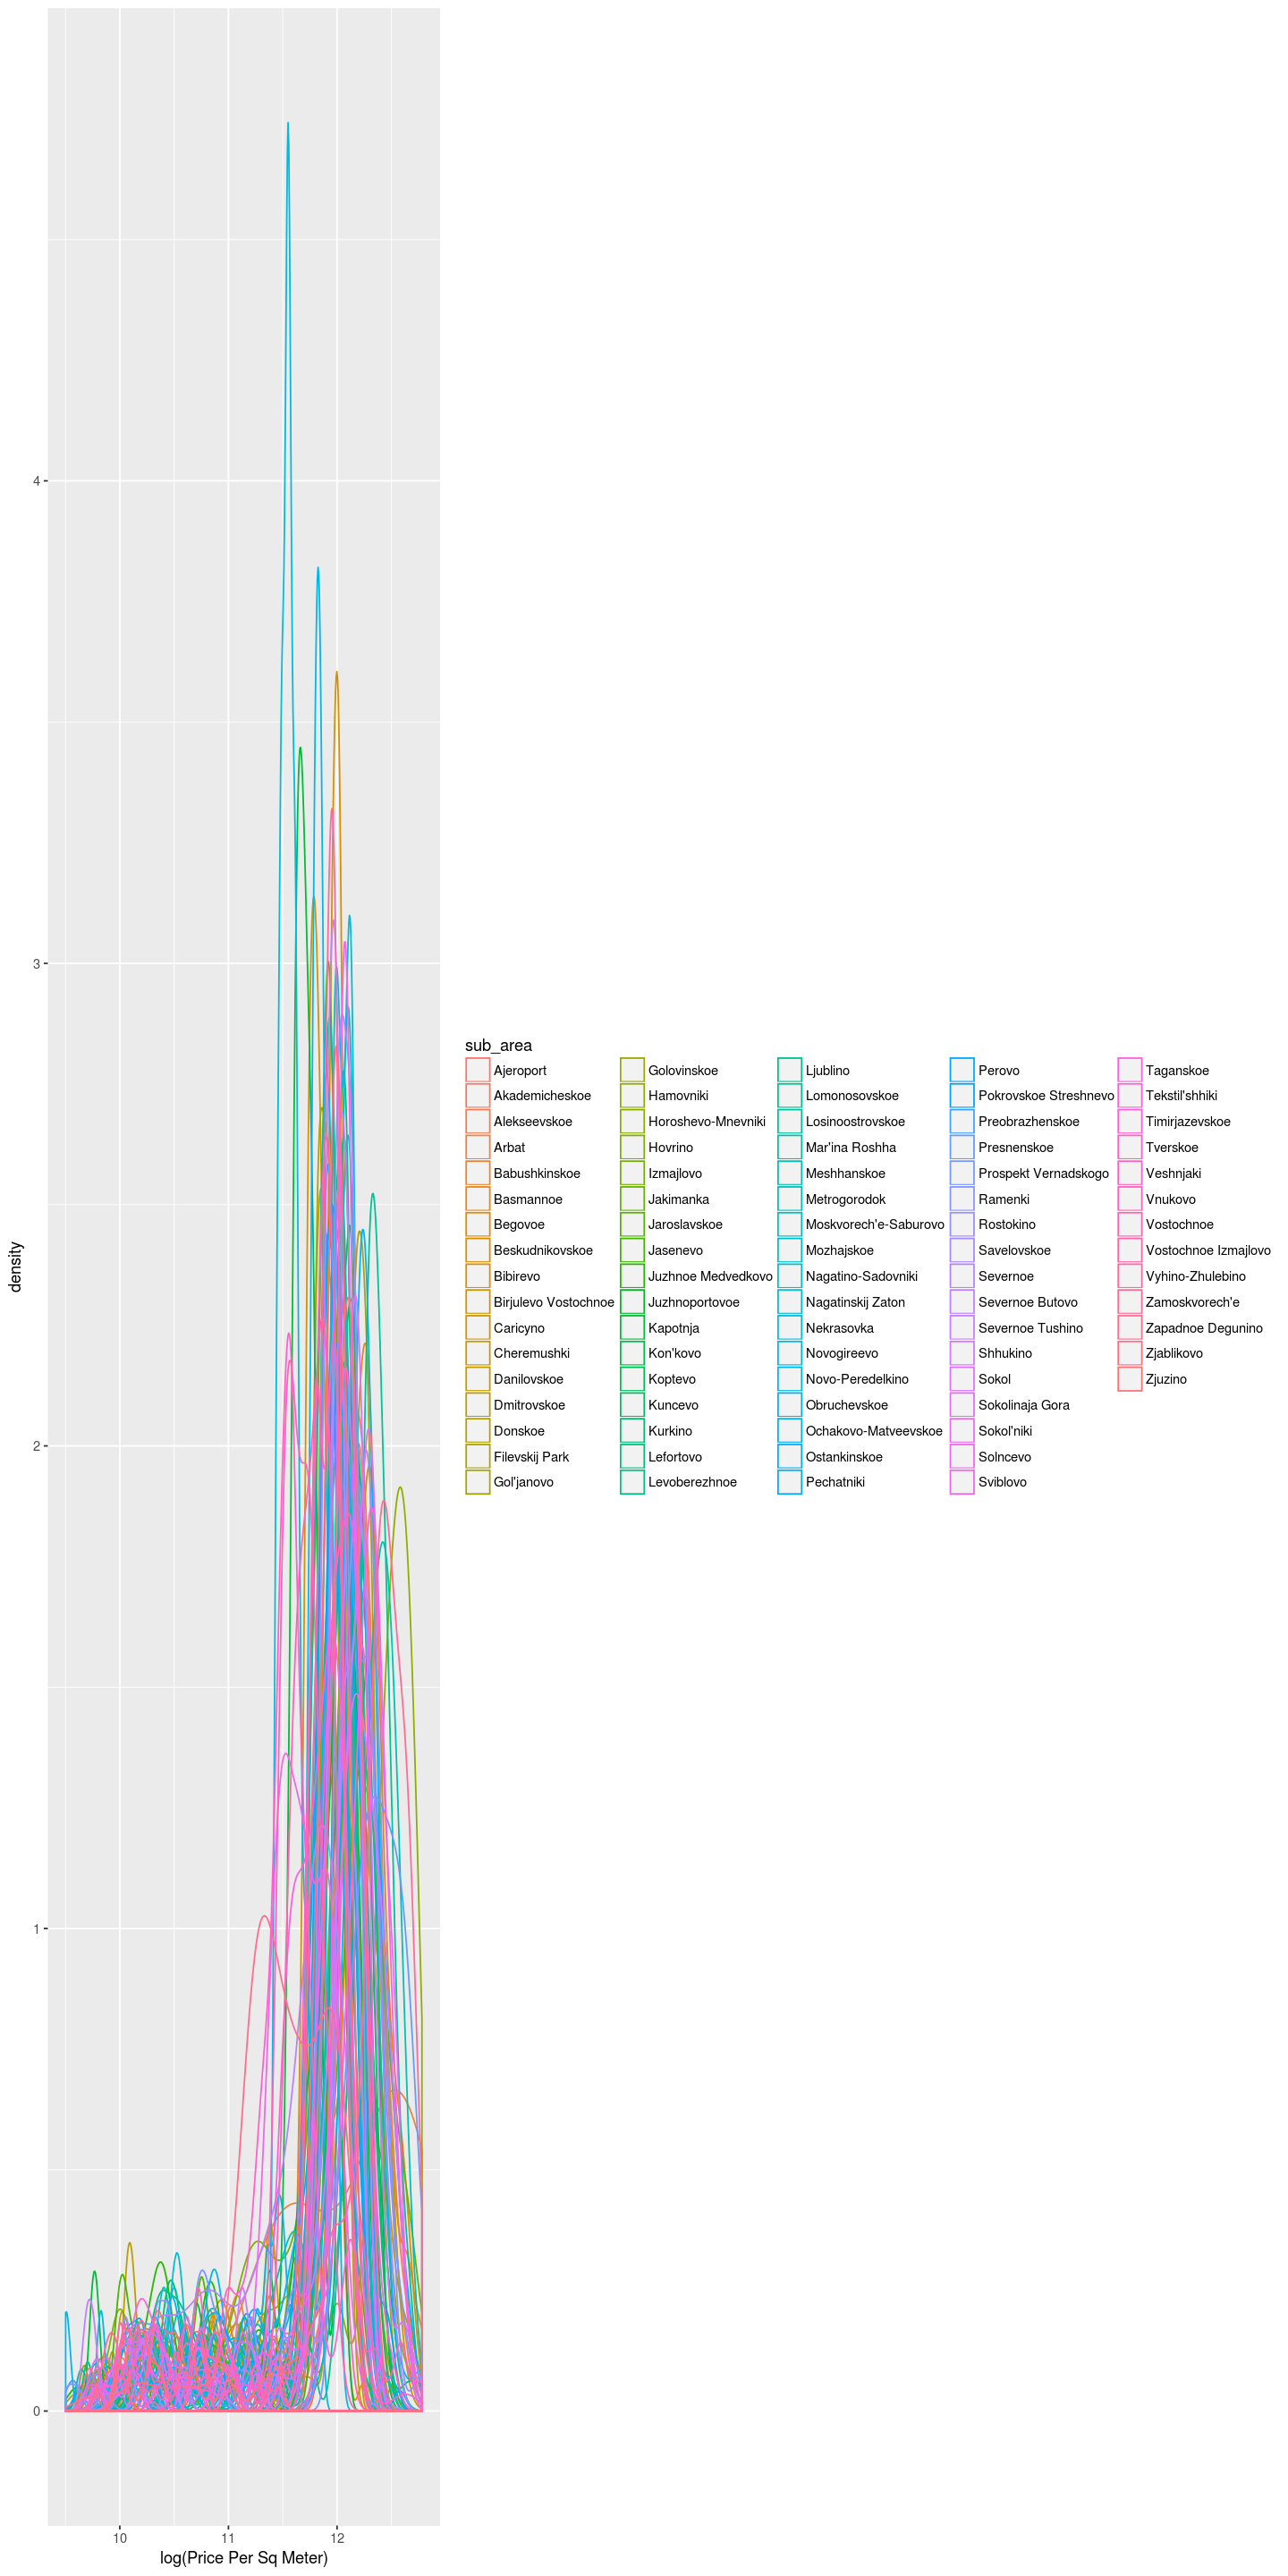

In [60]:
options(repr.plot.width=12, repr.plot.height=24)
ggplot(real_estate, aes(log.price_sqm)) + 
  geom_density(aes(color = sub_area)) + 
  xlab('log(Price Per Sq Meter)')


## Trim the tails, Plot again

Warning message:
“Removed 52 rows containing non-finite values (stat_density).”

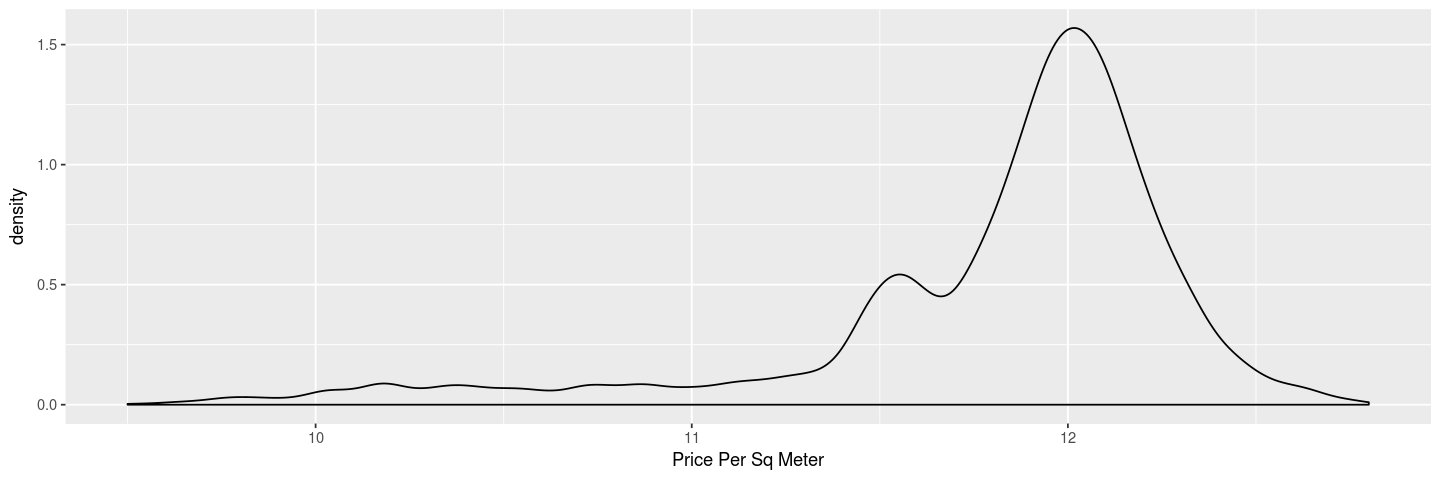

In [6]:
x_min = 9.5 # was 9.5
x_max = 12.8

ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter') + 
xlim(c(x_min, x_max)) 

## Use what we learned to trim the dataframe

In [7]:
real_estate.trimmed = real_estate[real_estate$log.price_sqm <= x_max,]
real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$log.price_sqm >= x_min,]
dim(real_estate)
dim(real_estate.trimmed)
real_estate = real_estate.trimmed

[1] 9233   70

[1] 9181   70

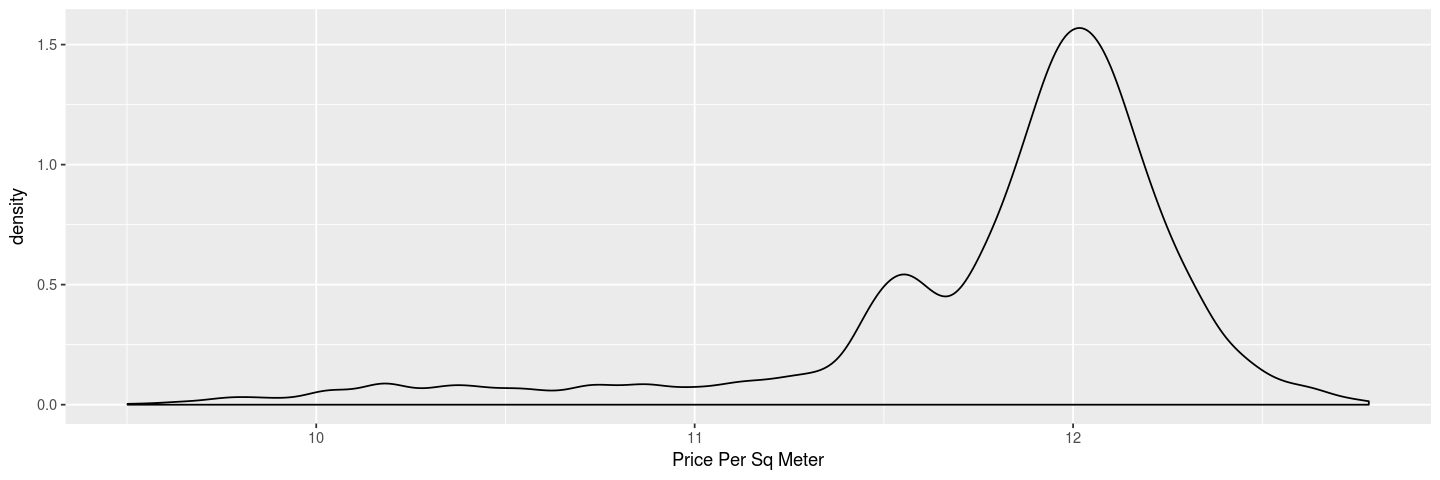

In [8]:
ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter')

## A Scatterng of Scatterplots: The search for meaning

Time to walk thru the dataset looking for features that have some kind of relationship with price per square foot. As we go along, we'll keep track of features which have non-zero trendlines, or that show promise as a categorical feature for splitting data.  Basically, we're looking for regression lines (solid green) with non-zero slopes and narrow confidence intervals (dashed red).  For categoricals, we're looking for "spiky" density plots.

Loading required package: car


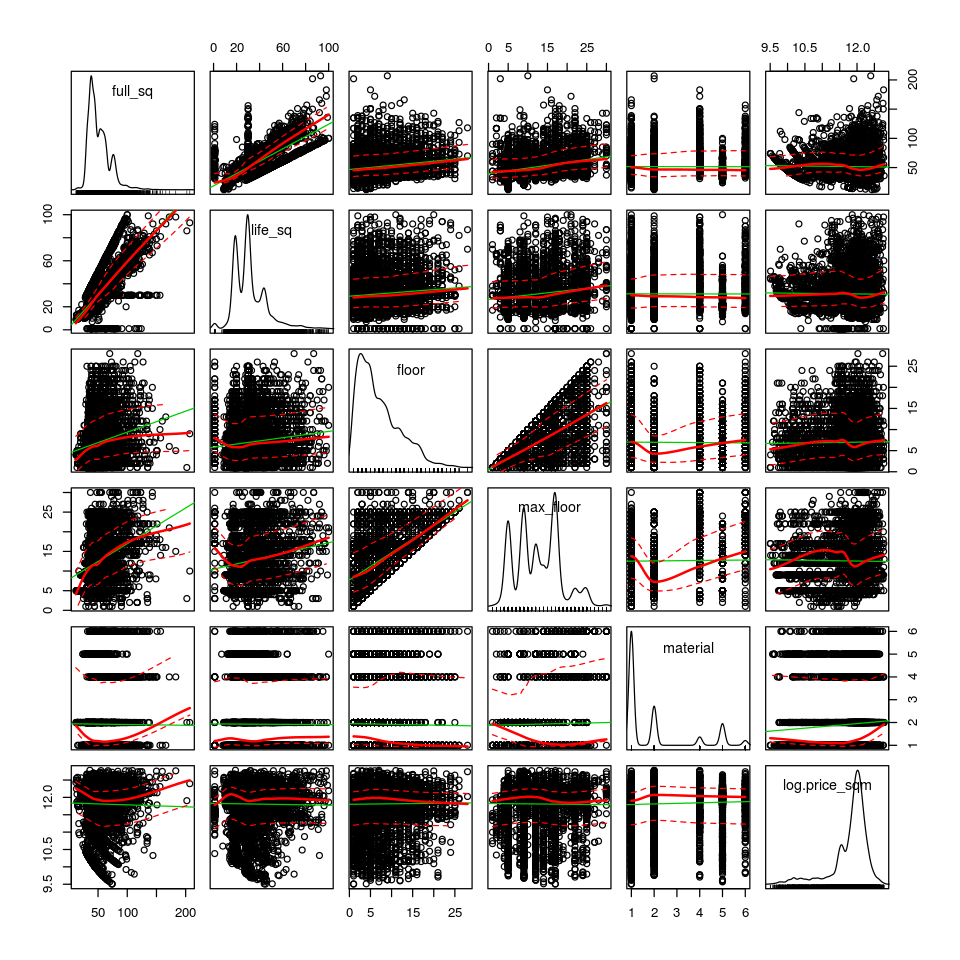

In [9]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  full_sq +
                  life_sq +
                  floor +
                  max_floor +
                  material +
                  log.price_sqm,
                  data = real_estate)

The rightmost column and and bottom row show relationships to log of the price per square foot (our target variable). The regression lines are all pretty flat, but **material** looks like a potential categorical variable. 

So far ...
- Potential numerics: none
- Potential categoricals: 1
  - material (5 values)
  
Moving on ...

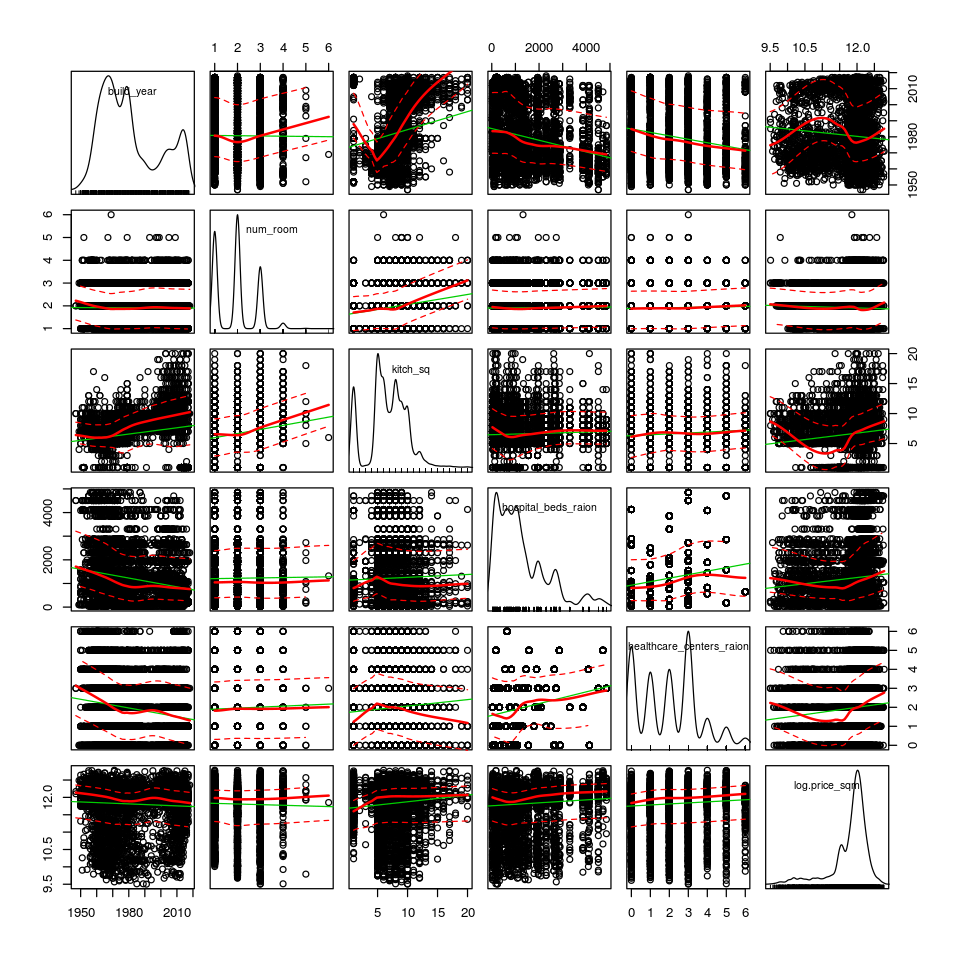

In [10]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                  build_year +
                  num_room +
                  kitch_sq +
                  hospital_beds_raion +
                  healthcare_centers_raion +
                  log.price_sqm,
                  data = real_estate)

**build_year**, **kitch_sq** and  **hospital_beds_raion** have some slope; **num_room** and **healthcare_centers_raion** are promising categoricals.

So far ...
- Potential numerics: 3
    - build_year
    - kitch_sq
    - hospital_beds_raion 
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next-up: state, office, metro stations

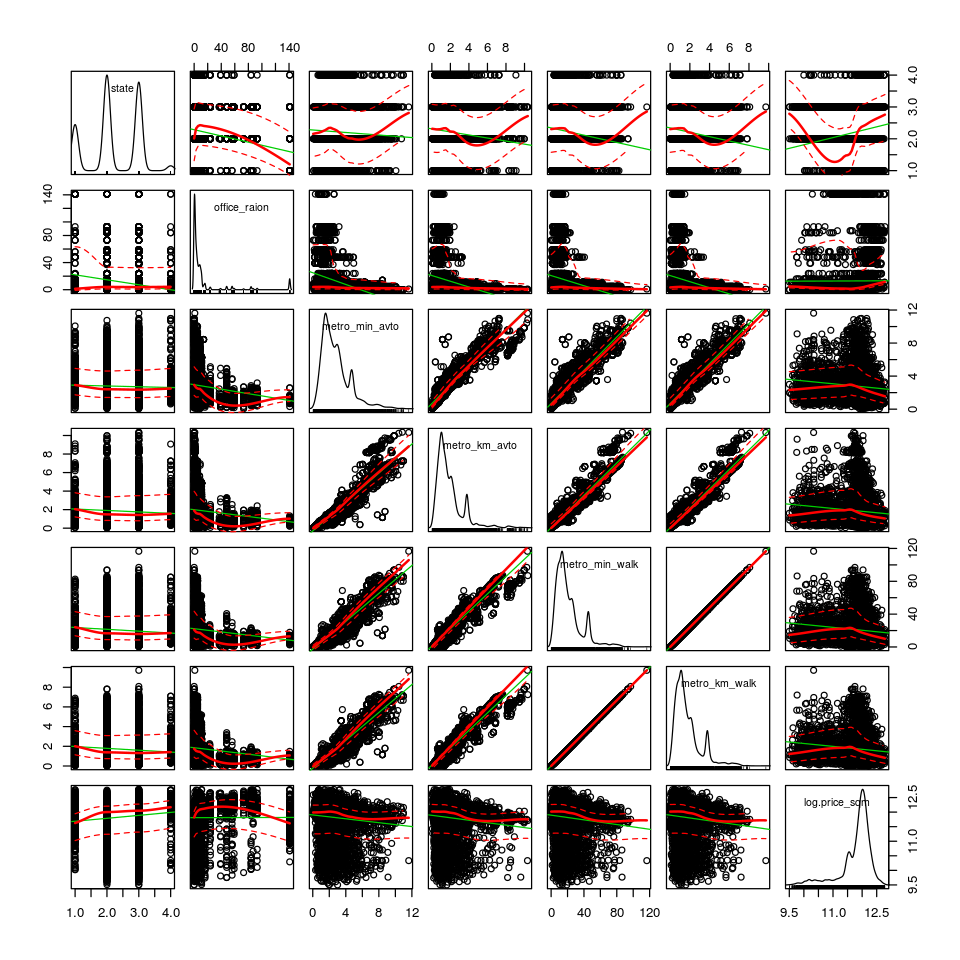

In [11]:
scatterplotMatrix(~ 
                 state +
                  office_raion   +
                  metro_min_avto +
                  metro_km_avto  +
                  metro_min_walk +
                  metro_km_walk +
                  log.price_sqm,
                  data = real_estate)

**state** is a promising categorical. The various **metro** params look similar, so we'll just pick one (**metro_km_walk**)

So far ...
- Potential numerics: 5
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next-up: railroad stations

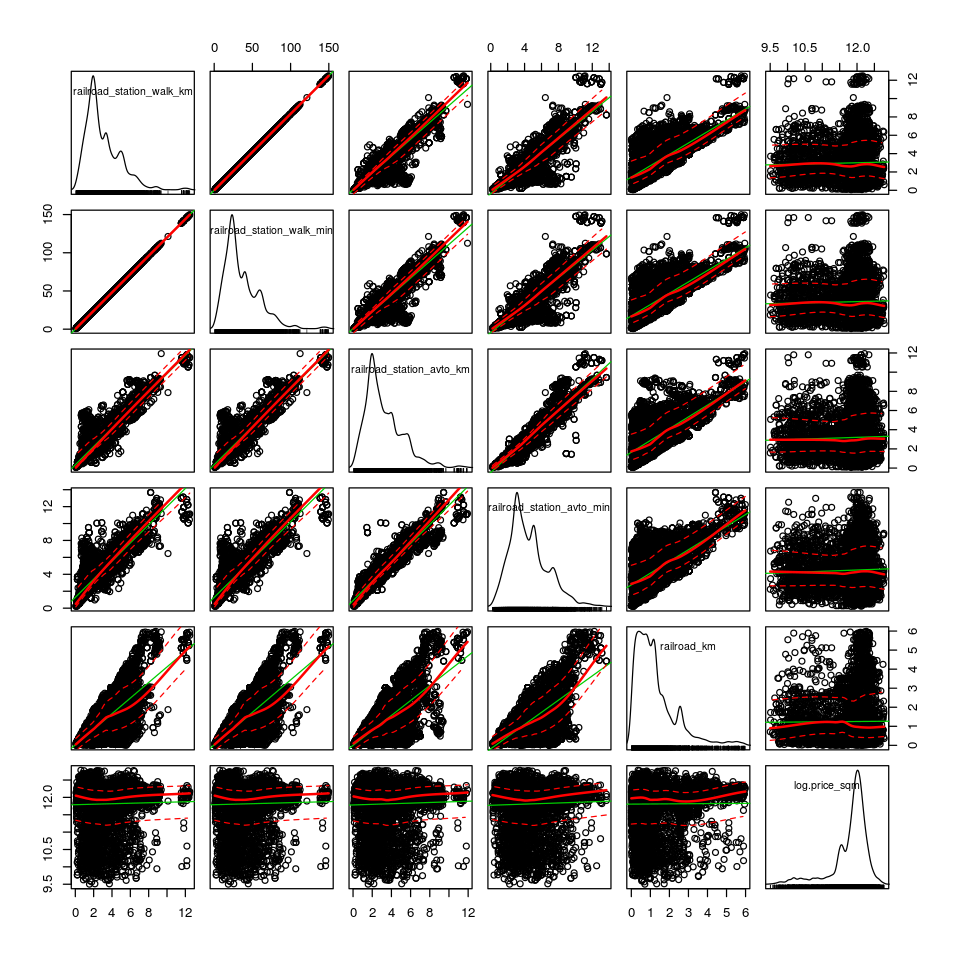

In [12]:
options(repr.plot.width=8, repr.plot.height=8)
require(car)

scatterplotMatrix(~ 
                    railroad_station_walk_km          +
                    railroad_station_walk_min         +
                    railroad_station_avto_km          +
                    railroad_station_avto_min         +
                   railroad_km                      +
                  log.price_sqm,
                  data = real_estate)

Similar story to the  **metro** series. Regression lines are all flat, so we'll skip these. 

So far ...
- Potential numerics: 5
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next-up: public transpot, roads, a few others.

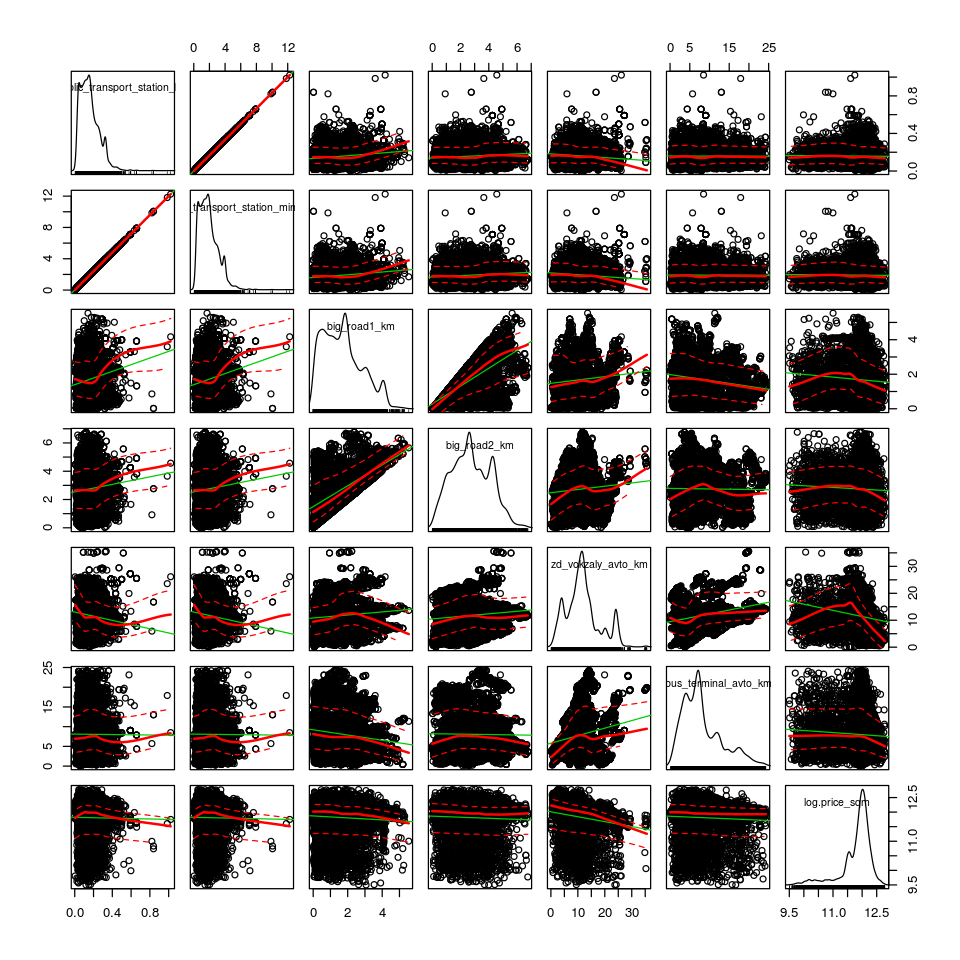

In [13]:
scatterplotMatrix(~ 
                public_transport_station_km       +
                public_transport_station_min_walk +
                big_road1_km                     +
                big_road2_km                     +
                zd_vokzaly_avto_km               +
                bus_terminal_avto_km             +
                  log.price_sqm,
                  data = real_estate)

**zd_vokzaly_avto_km** has a nice slope.

So far ...
- Potential numerics: 6
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next up: oil, hospic, detention, public healthcare

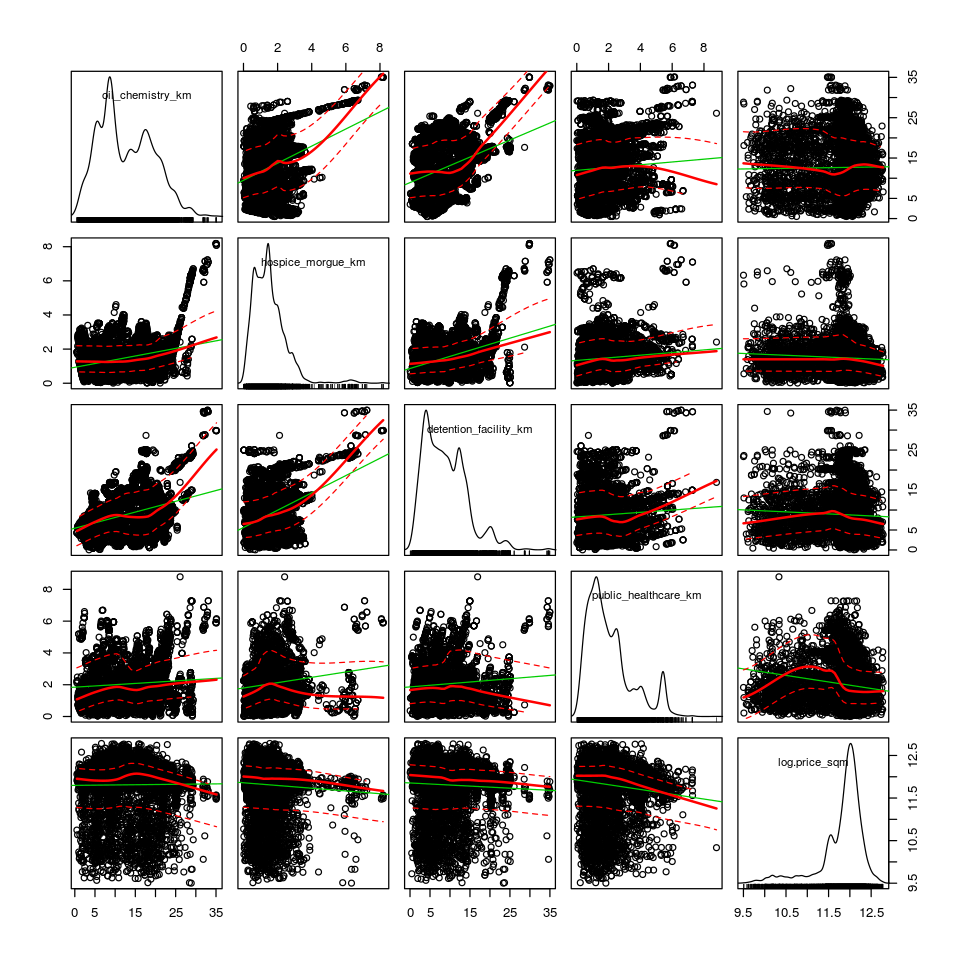

In [14]:
scatterplotMatrix(~ 
                oil_chemistry_km                 +
                hospice_morgue_km                +
                detention_facility_km            +
                public_healthcare_km             +
                  log.price_sqm,
                  data = real_estate)

**public_healthcare_km** has some slope.

So far ...
- Potential numerics: 7
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next up: offices

Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
“could not fit smooth”

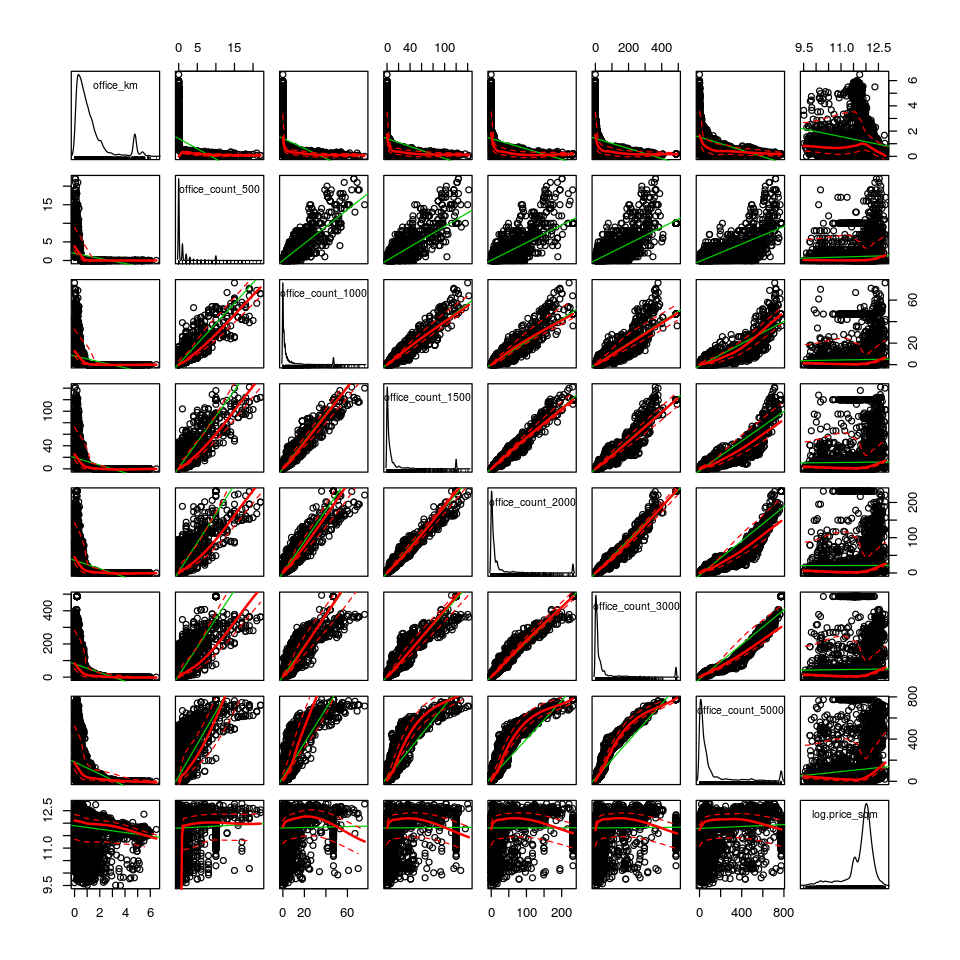

In [15]:
scatterplotMatrix(~ 
                office_km                        +
                office_count_500                 +
                office_count_1000                +
                office_count_1500                +
                office_count_2000                +
                office_count_3000                +
                office_count_5000                +
                  log.price_sqm,
                  data = real_estate)

**office_km** has some slope.

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next up: promenades

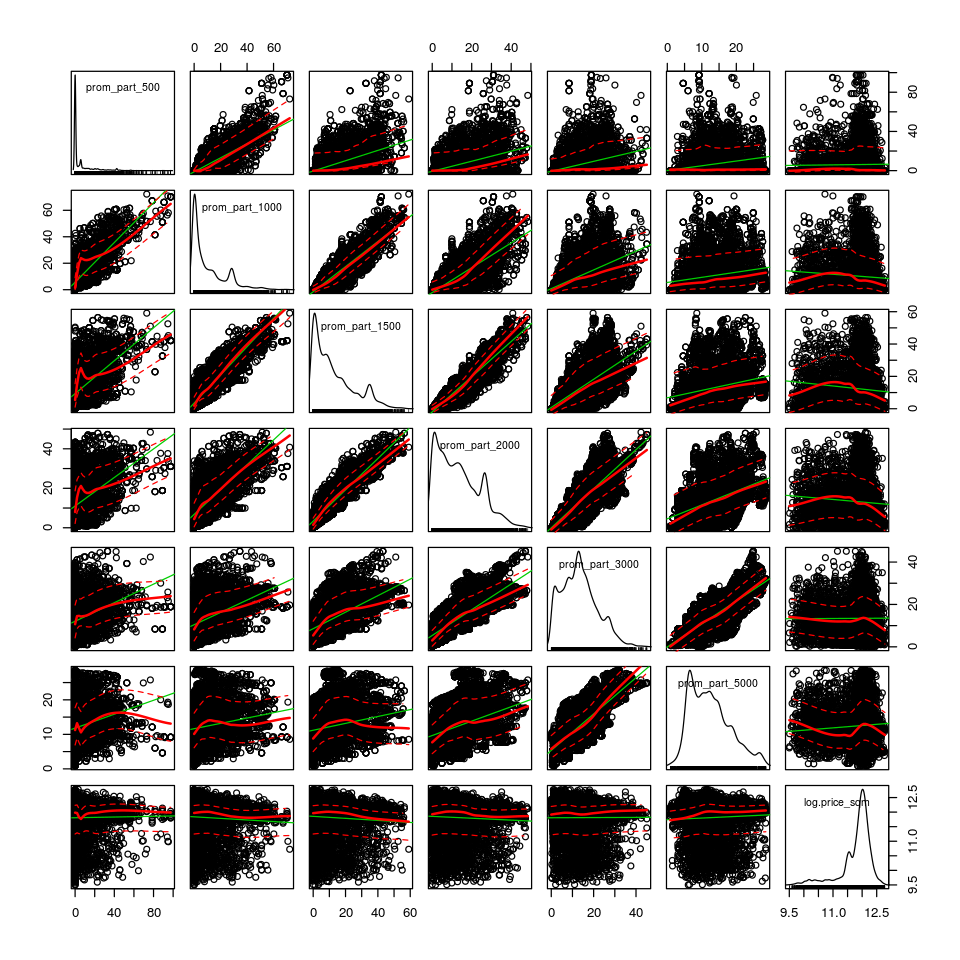

In [16]:
scatterplotMatrix(~ 
                  prom_part_500                    +
                  prom_part_1000                   +
                  prom_part_1500                   +
                  prom_part_2000                   +
                  prom_part_3000                   +
                  prom_part_5000                   +

                  log.price_sqm,
                  data = real_estate)

Best slope seems to be out of **prom_part_1500** 

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
    - prom_part_1500
- Potential categoricals: 3
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)

Next up: yearbuilt, year sold, and others

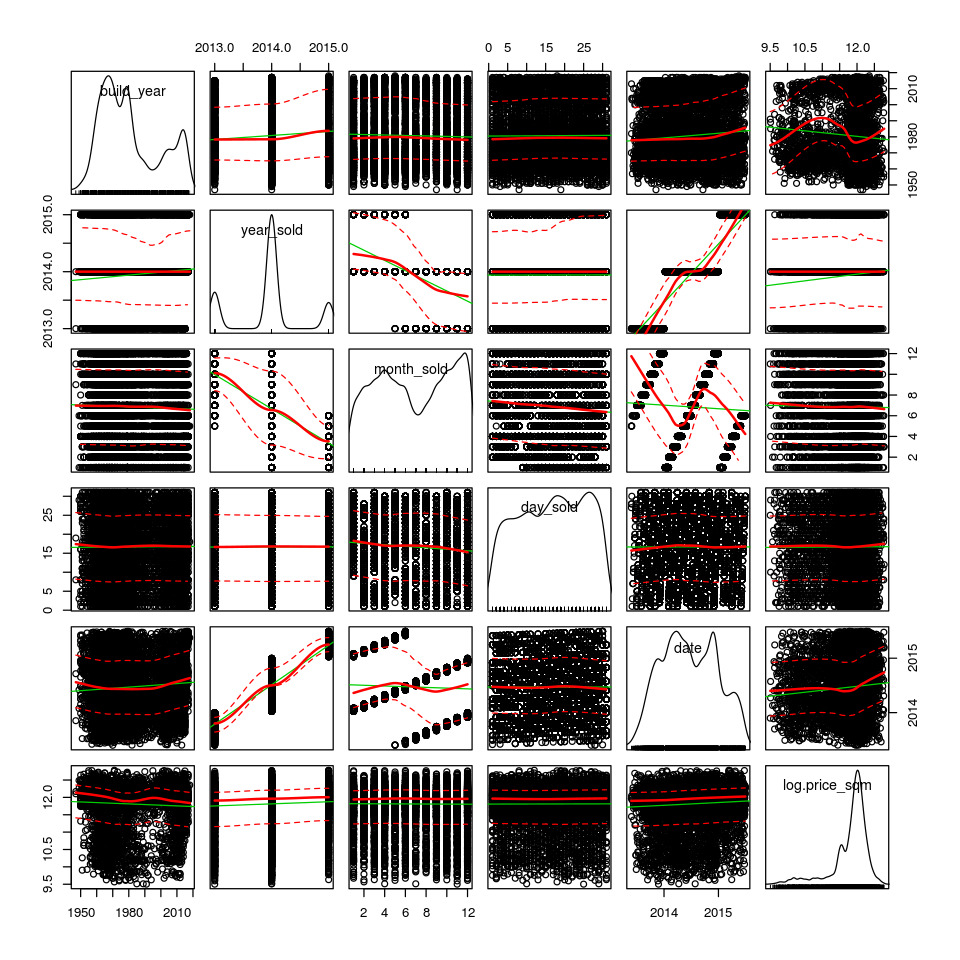

In [17]:
scatterplotMatrix(~ 
                  build_year +
                  year_sold +
                  month_sold +
                  day_sold +
                  date +
                  log.price_sqm,
                  data = real_estate)

**year_sold** has potential as a categorical, **month_sold** suggests some seasonality.

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
    - prom_part_1500
- Potential categoricals: 4
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)
  - year_sold (3 values)
  - month_sold (12 values)

Next-up: Look at what we got

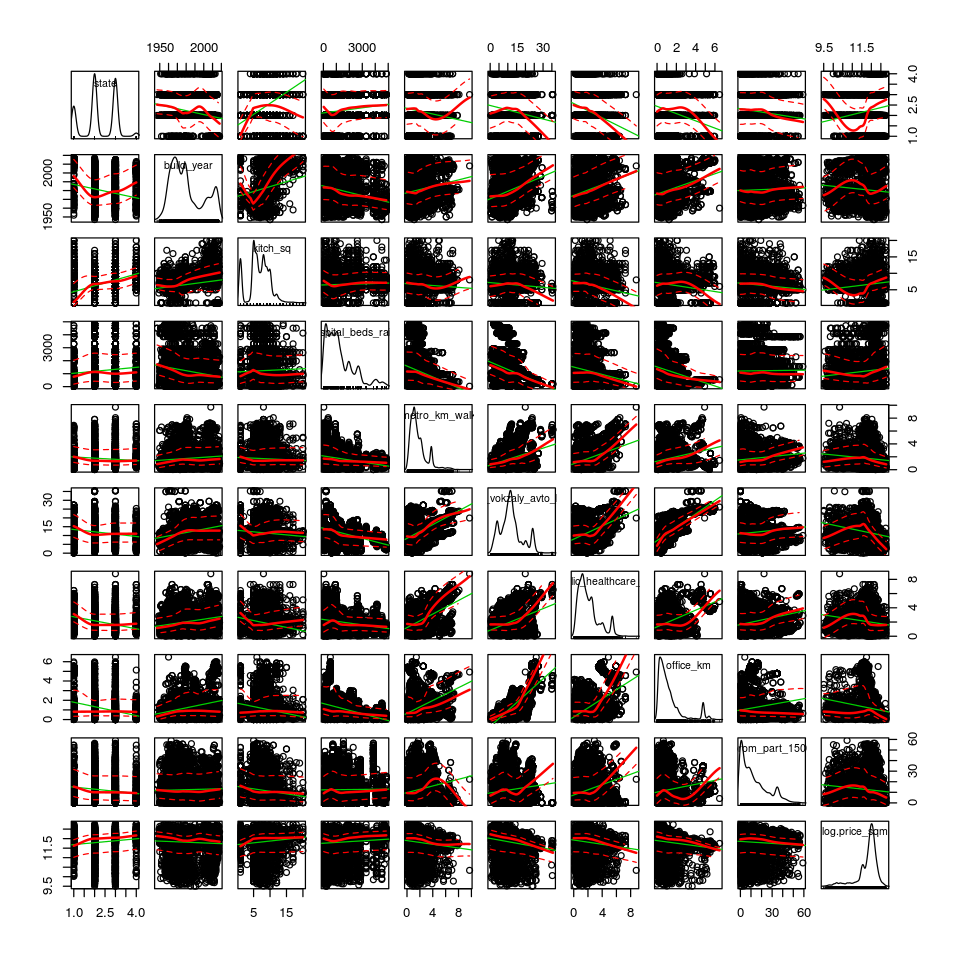

In [18]:
scatterplotMatrix(~ 
                  state +
                  build_year +
                  kitch_sq +
                  hospital_beds_raion +
                  metro_km_walk +
                  zd_vokzaly_avto_km +
                  public_healthcare_km +
                  office_km +
                  prom_part_1500 +
                  log.price_sqm,
                  data = real_estate)

It's imortant to note how _non-linear_ all the scatterplots are when **log.price_sqm** is involved. Before we model, we have to find a way to extract a subset. 

## Slice, Dice, and Extract

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
    - prom_part_1500
- Potential categoricals: 5
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)
  - year_sold (3 values)
  - month_sold (12 values)

## Stepwise Regression

_Use the stepAIC function from the MASS package to perform stepwise regression starting with the linear model including all features. Which features are remain in the model? Evaluate this model using the summary and plot methods for your model object._

In [21]:
# drops = c("timestamp", "date", "max_floor")
drops = c("timestamp")
real_esate.premodel = real_estate[,!(names(real_estate) %in% drops)]

lm.real_estate = lm(log.price_sqm ~ ., data = real_esate.premodel)
summary(lm.real_estate )


Call:
lm(formula = log.price_sqm ~ ., data = real_esate.premodel)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.14712 -0.03547  0.02474  0.07353  0.66045 

Coefficients: (9 not defined because of singularities)
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        4.297e+03  1.713e+03   2.508 0.012174 *  
full_sq                            2.009e-03  3.140e-04   6.397 1.66e-10 ***
life_sq                            3.623e-04  1.985e-04   1.825 0.068079 .  
floor                             -9.569e-04  4.064e-04  -2.355 0.018565 *  
max_floor                         -2.567e-03  4.835e-04  -5.310 1.12e-07 ***
material                          -1.505e-03  1.160e-03  -1.298 0.194200    
build_year                        -6.136e-04  1.429e-04  -4.295 1.76e-05 ***
num_room                           2.190e-02  4.144e-03   5.285 1.29e-07 ***
kitch_sq                           4.486e-04  8.142e-04   0.551 0.581650    
sta

In [25]:
coeffs = c(
    'full_sq',
    'max_floor',
    'build_year',
    'num_room',
    'state',
    'product_typeOwnerOccupier',
    'sub_areaHamovniki',
    'sub_areaLomonosovskoe',
    'sub_areaPresnenskoe',
    'sub_areaTimirjazevskoe',
    'railroad_station_walk_km',
    'sadovoe_km',
    'bulvar_ring_km',
    'oil_chemistry_km',
    'office_count_1000',
    'office_sqm_1500',
    'office_sqm_2000',
    'office_count_5000',
    'price_doc',
    'price_sqm',
    'log.price_sqm'
    )


In [26]:
# drops = c("timestamp", "date", "max_floor")
drops = c("timestamp")
real_esate.premodel2 = real_estate[,(names(real_estate) %in% coeffs)]

lm.real_estate2 = lm(log.price_sqm ~ ., data = real_esate.premodel2)
summary(lm.real_estate2 )


Call:
lm(formula = log.price_sqm ~ ., data = real_esate.premodel2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.14032 -0.04059  0.03364  0.09680  0.39176 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.050e+01  2.750e-01  38.175  < 2e-16 ***
full_sq                   2.588e-03  3.144e-04   8.232  < 2e-16 ***
max_floor                -1.955e-03  4.374e-04  -4.469 7.95e-06 ***
build_year               -7.516e-05  1.410e-04  -0.533 0.593923    
num_room                  1.781e-02  3.998e-03   4.456 8.46e-06 ***
state                    -4.435e-02  2.465e-03 -17.990  < 2e-16 ***
railroad_station_walk_km -5.360e-03  9.470e-04  -5.660 1.56e-08 ***
sadovoe_km                9.037e-02  4.230e-03  21.363  < 2e-16 ***
bulvar_ring_km           -7.641e-02  4.248e-03 -17.985  < 2e-16 ***
oil_chemistry_km         -4.188e-03  2.854e-04 -14.677  < 2e-16 ***
office_count_1000        -5.982e-04  4.976e-04  -1.202 0.229264  

In [28]:
# drops = c("timestamp", "date", "max_floor")
drops2 = c("build_year", "office_count_1000")
real_esate.premodel3 = real_esate.premodel2[,!(names(real_esate.premodel2) %in% drops2)]

lm.real_estate3 = lm(log.price_sqm ~ ., data = real_esate.premodel3)
summary(lm.real_estate3)


Call:
lm(formula = log.price_sqm ~ ., data = real_esate.premodel3)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.14119 -0.03987  0.03373  0.09635  0.39425 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.035e+01  1.784e-02 580.417  < 2e-16 ***
full_sq                   2.555e-03  3.077e-04   8.305  < 2e-16 ***
max_floor                -2.082e-03  3.621e-04  -5.751 9.16e-09 ***
num_room                  1.840e-02  3.869e-03   4.755 2.01e-06 ***
state                    -4.442e-02  2.465e-03 -18.023  < 2e-16 ***
railroad_station_walk_km -5.498e-03  9.409e-04  -5.843 5.29e-09 ***
sadovoe_km                8.815e-02  3.846e-03  22.923  < 2e-16 ***
bulvar_ring_km           -7.438e-02  3.925e-03 -18.949  < 2e-16 ***
oil_chemistry_km         -4.173e-03  2.850e-04 -14.641  < 2e-16 ***
office_sqm_1500           7.789e-08  1.445e-08   5.392 7.14e-08 ***
office_sqm_2000          -3.227e-08  9.469e-09  -3.408 0.000658 *

Okay, if we do nothing, we have an $R^2_{adj}$ of 0.9017 Now let's try running StepAIC()


In [29]:
library(MASS)
lm.step = stepAIC(lm.real_estate3, direction = 'both')
lm.step$anova # ANOVA of the result

Start:  AIC=-33228.17
log.price_sqm ~ full_sq + max_floor + num_room + state + railroad_station_walk_km + 
    sadovoe_km + bulvar_ring_km + oil_chemistry_km + office_sqm_1500 + 
    office_sqm_2000 + office_count_5000 + price_doc + price_sqm

                           Df Sum of Sq    RSS    AIC
<none>                                  245.33 -33228
- office_sqm_2000           1      0.31 245.64 -33219
- num_room                  1      0.61 245.94 -33208
- office_sqm_1500           1      0.78 246.11 -33201
- max_floor                 1      0.89 246.22 -33197
- railroad_station_walk_km  1      0.91 246.25 -33196
- office_count_5000         1      1.23 246.56 -33184
- full_sq                   1      1.85 247.18 -33161
- oil_chemistry_km          1      5.74 251.07 -33018
- price_doc                 1      5.78 251.11 -33016
- state                     1      8.69 254.02 -32910
- bulvar_ring_km            1      9.61 254.94 -32877
- sadovoe_km                1     14.06 259.39 -32718


Step Df Deviance Resid. Df Resid. Dev AIC      
1      NA NA       9167      245.3312   -33228.17

### Residuals vs. Fitted

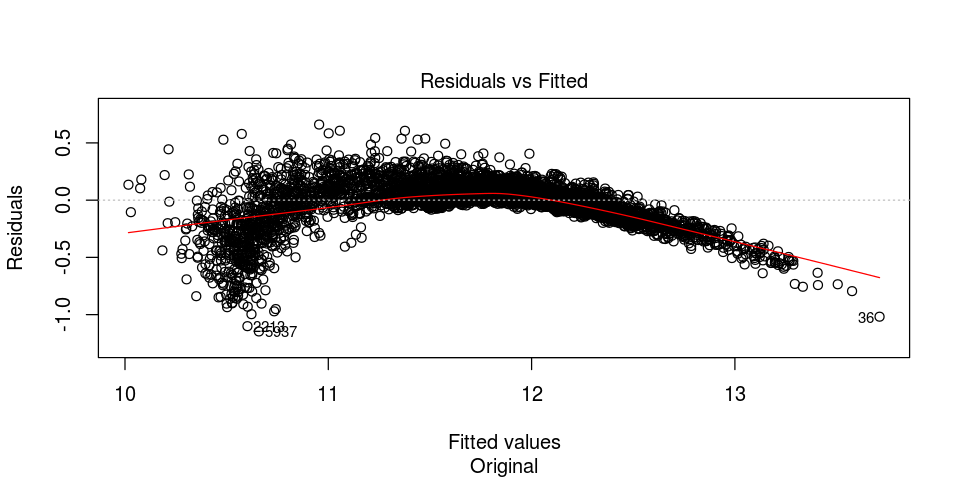

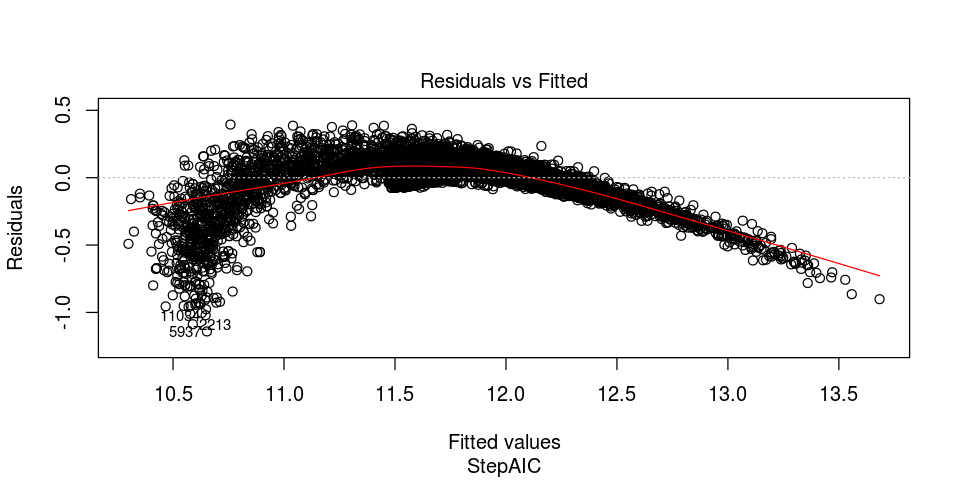

In [30]:
options(repr.plot.width=8, repr.plot.height=4)
plot(lm.real_estate,  which =1, sub.caption="Original") 
plot(lm.step,         which =1, sub.caption="StepAIC")

#### Pretty hard to see a difference, but we're expecting that, since we already know the Residual standard error didn't change much. [VERIFY]

### Normal Q-Q

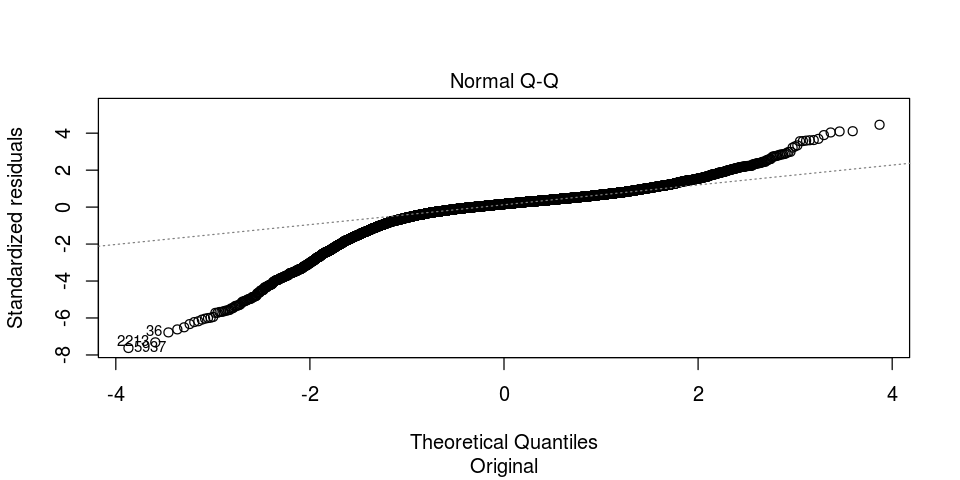

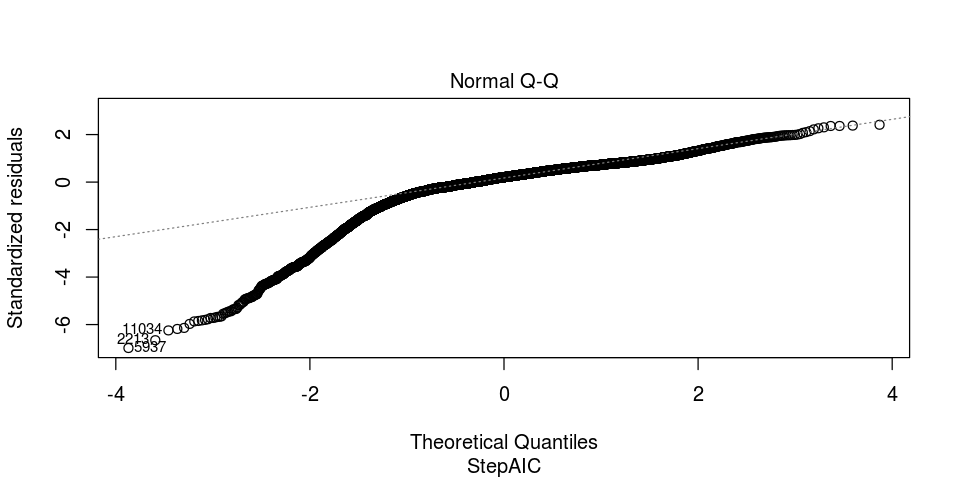

In [31]:
plot(lm.real_estate, which =2, sub.caption= "Original") 
plot(lm.step,        which =2, sub.caption= "StepAIC") 

### $\sqrt{Standardized Residuals}$ vs. Fitted Values 

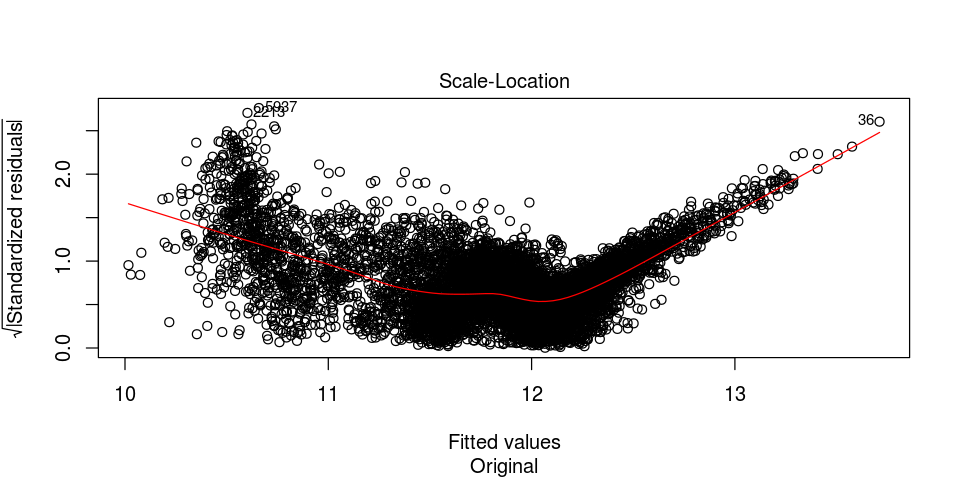

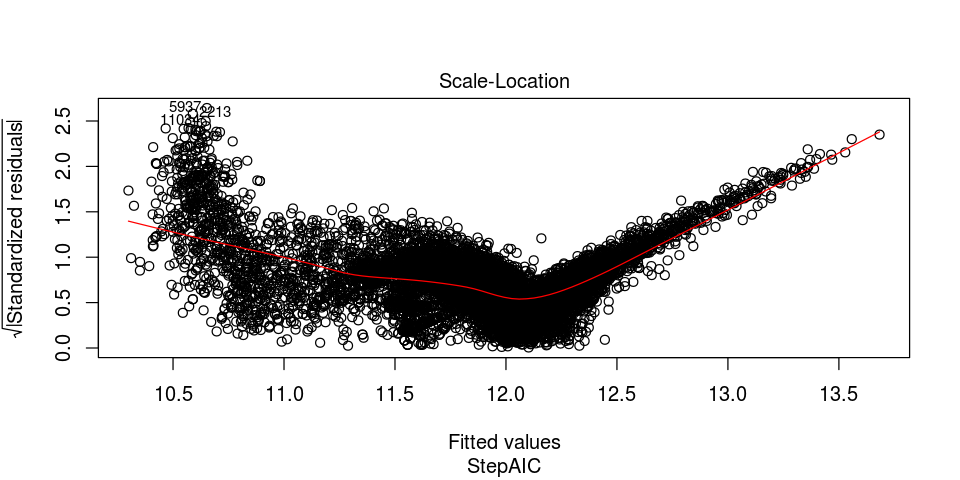

In [32]:
plot(lm.real_estate, which =3, sub.caption="Original") 
plot(lm.step,  which =3, sub.caption="StepAIC") 

### Residuals vs. Leverage

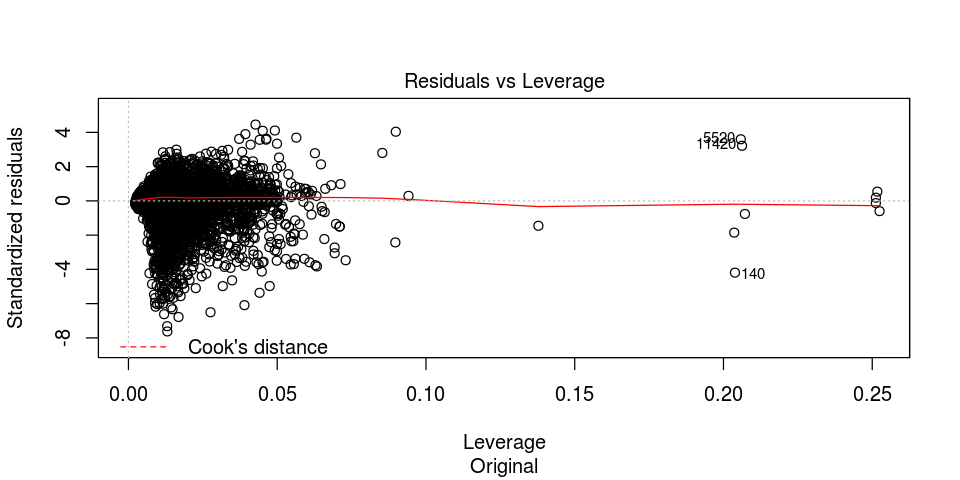

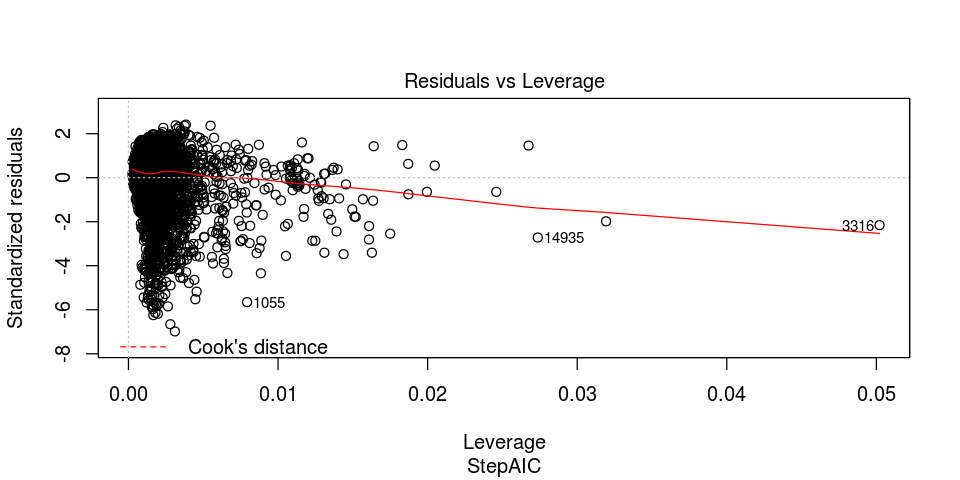

In [33]:
plot(lm.real_estate, which =5, sub.caption="Original")
plot(lm.step,  which =5, sub.caption="StepAIC")

# SVD Regression

In [62]:
mod.mat = model.matrix(log.price_sqm ~ . -1, data = real_estate.scaled)
head(mod.mat)
dim(mod.mat)
range(mod.mat)

ERROR: Error in terms.formula(object, data = data): object 'real_estate.scaled' not found


In [61]:
svdM = svd(mod.mat)
d = svdM$d
plot(log(d))

ERROR: Error in as.matrix(x): object 'mod.mat' not found
